---

В этом ноутбке мы научимся писать свои свёрточные нейросети на фреймворке PyTorch, и протестируем их работу на датасетах MNIST и CIFAR10.

**ВНИМАНИЕ:** Рассматривается ***задача классификации изображений***.

(Подразумевается, что читатель уже знаком с многослойной нейроннной сетью).  

***Свёрточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоёв* (а иногда их может и не быть) ещё и **свёрточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свёртки**.


Сразу же стоит сказать, что свёрточные нейросети **были придуманы прежде всего для задач, связанных с картинками**, следовательно, на вход они тоже "ожидают" картинку.

Расмотрим их устройство более подробно:

* Вот так выглядит неглубокая свёрточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>

Свёрточные нейросети (обыкновенные, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`  

то есть:  

1). ***Входной слой*** (batch картинок `HxWxC`)  

2). $M$ блоков (M $\ge$ 0) из свёрток и pooling-ов, причём именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков, поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чтем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $K$ штук FullyConnected-слоёв (с активациями). Эту часть из $K$ FC-слоёв называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

Какими их берут обычно -- будет показано в примере ниже. По крайней мере, можете стартовать с этих настроек, чтобы понять, какое качество "из коробки" будет у простой модели.

Посмотрим, как работает CNN на MNIST'е и на CIFAR'е:

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

**MNIST:** это набор из 70k картинок рукописных цифр от 0 до 9, написанных людьми, 60k из которых являются тренировочной выборкой (`train` dataset)), и ещё 10k выделены для тестирования модели (`test` dataset).

In [ ]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Сами данные лежат в полях `trainloader.dataset.train_data` и `testloader.dataset.test_data`:

In [ ]:
trainloader.dataset.train_data.shape

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [ ]:
testloader.dataset.test_data.shape

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

Выведем первую картинку:

In [ ]:
trainloader.dataset.train_data[0]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Посмотрим, как она выглядит:

In [ ]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.train_data[0].numpy()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
numpy_img.shape

(28, 28)

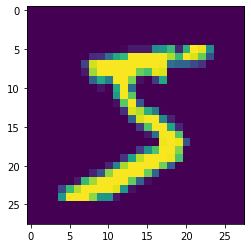

In [ ]:
plt.imshow(numpy_img);

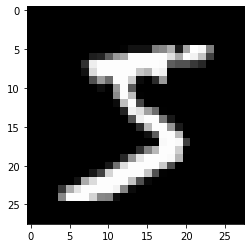

In [ ]:
plt.imshow(numpy_img, cmap='gray');

Отрисовка заданной цифры:

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


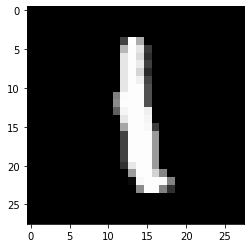

In [ ]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)

plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

Как итерироваться по данным с помощью `loader'`а? Очень просто:

In [ ]:
for data in trainloader:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернёмся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Seuquential`. Испольузем  `Functional` парадигму, потому что при построении свёрточных сетей это намного удобнее:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [ ]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Важное примечание:** Вы можете заметить, что в строчках с `#!!!` есть не очень понятный сходу 4 `*` 4 `*` 16. Это -- размерность картинки перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, `.Flatten()` всё делает за Вас). Однако есть один *лайфхак* -- просто сделайте в `forward()` `print(x.shape)` (закомментированная строка). Вы увидите размер `(batch_size, C, H, W)` -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность `Linear()`, и именно в C * H * W нужно "развернуть" x перед подачей в `Linear()`.  

То есть нужно будет запустить цикл с обучением первый раз с `print()` и сделать после него `break`, посчитать размер, вписать его в нужные места и стереть `print()` и `break`.

Код обучения слоя:

In [ ]:
from tqdm import tqdm

In [ ]:
# объявляем сеть
net = SimpleConvNet()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm(range(3)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

 13%|█▎        | 2018/15000 [00:17<02:00, 107.69it/s]

[1,  2000] loss: 0.988



 27%|██▋       | 4014/15000 [00:34<01:32, 119.19it/s]

[1,  4000] loss: 0.384



 40%|████      | 6025/15000 [00:51<01:13, 121.52it/s]

[1,  6000] loss: 0.307



 53%|█████▎    | 8017/15000 [01:07<00:56, 122.56it/s]

[1,  8000] loss: 0.242



 67%|██████▋   | 10020/15000 [01:24<00:41, 119.95it/s]

[1, 10000] loss: 0.218



 80%|████████  | 12005/15000 [01:42<00:51, 58.05it/s]

[1, 12000] loss: 0.182



 93%|█████████▎| 14018/15000 [02:02<00:07, 124.38it/s]

[1, 14000] loss: 0.162



 13%|█▎        | 2013/15000 [00:17<01:48, 120.16it/s]

[2,  2000] loss: 0.137



 27%|██▋       | 4018/15000 [00:33<01:29, 122.18it/s]

[2,  4000] loss: 0.115



 40%|████      | 6015/15000 [00:50<01:19, 113.02it/s]

[2,  6000] loss: 0.118



 53%|█████▎    | 8019/15000 [01:07<00:57, 121.27it/s]

[2,  8000] loss: 0.100



 67%|██████▋   | 10020/15000 [01:24<00:45, 108.49it/s]

[2, 10000] loss: 0.126



 80%|████████  | 12021/15000 [01:41<00:25, 117.29it/s]

[2, 12000] loss: 0.109



 94%|█████████▎| 14025/15000 [01:57<00:08, 120.65it/s]

[2, 14000] loss: 0.106



 13%|█▎        | 2020/15000 [00:17<01:52, 115.17it/s]

[3,  2000] loss: 0.085



 27%|██▋       | 4019/15000 [00:34<01:33, 117.10it/s]

[3,  4000] loss: 0.081



 40%|████      | 6015/15000 [00:51<01:18, 114.87it/s]

[3,  6000] loss: 0.094



 53%|█████▎    | 8018/15000 [01:09<00:59, 117.94it/s]

[3,  8000] loss: 0.079



 67%|██████▋   | 10018/15000 [01:26<00:40, 124.37it/s]

[3, 10000] loss: 0.083



 80%|████████  | 12025/15000 [01:44<00:24, 122.54it/s]

[3, 12000] loss: 0.079



 93%|█████████▎| 14023/15000 [02:01<00:08, 116.45it/s]

[3, 14000] loss: 0.069



100%|██████████| 3/3 [06:26<00:00, 129.00s/it]

Обучение закончено


Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 98 %
Accuracy of     2 : 96 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 95 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %


Два свёрточных слоя побили многослойную нейросеть. Не магия ли?

---

### Задача 1

Протестируйте эту нейросеть на отдельных картинках из тестового датасета: напишите функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

In [ ]:
def predict_on_test_example(idx):

    img, label = testset[idx]
    plt.imshow(img.squeeze().numpy())
    y_pred = net(img.unsqueeze(dim=0))
    _, predicted = torch.max(y_pred, 1)
    print(f'Модель предсказала класс {predicted.item()}')

Модель предсказала класс 1


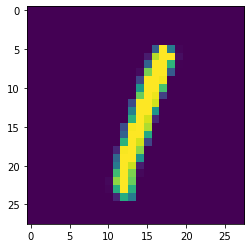

In [ ]:
predict_on_test_example(5);

---

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именн он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='D:/nvb/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='D:/nvb//data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


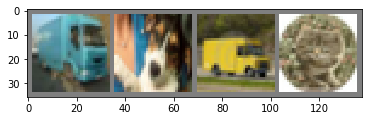

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Функция, которая показывает изображения
def imshow(img):
    img = img / 2 + 0.5     # деномрировка
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# достаем случайные картинки из обучающей выборки
dataiter = iter(trainloader)
images, labels = dataiter.next()

# вызываем функцию, реализующую демонстрацию изображений, что мы можем видеть на них?
imshow(torchvision.utils.make_grid(images))

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Данные готовы, мы даже на них посмотрели. **Однако учтите** - при подаче в нейросеть мы будем разворачивать картинку 32х32х3 в строку 1х(32`*`32`*`3) = 1х3072, то есть мы считаем пиксели (значения интенсивности в пикселях) за признаки нашего объекта (картинки).  

К делу:

### Задача 2

Напишите свою свёрточную нейросеть для предсказания на CIFAR10.

In [ ]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 765, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 765)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [ ]:
from tqdm import tqdm

In [ ]:
# пример взят из официального туториала:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

net = MyConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # РАЗВОРАЧИВАЕМ КАРТИНКУ В СТРОКУ
        X_batch = X_batch.view(4, -1)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

  2%|█▌                                                                            | 253/12500 [00:14<05:55, 34.40it/s]


  4%|███▏                                                                          | 517/12500 [00:22<05:56, 33.61it/s]


  6%|████▋                                                                         | 755/12500 [00:29<07:22, 26.55it/s]


  8%|█████▉                                                                        | 954/12500 [00:37<07:23, 26.01it/s]


  9%|███████                                                                      | 1153/12500 [00:45<07:06, 26.61it/s]


 11%|████████▎                                                                    | 1351/12500 [00:52<07:15, 25.60it/s]


 12%|█████████▌                                                                   | 1549/12500 [01:00<07:04, 25.77it/s]


 14%|██████████▊                                                                  | 1748/12500 [01:08<06:54, 25.94it/s]


 16%|███████████▉                                                                 | 1947/12500 [01:15<06:40, 26.32it/s]


 16%|████████████▎                                                                | 2004/12500 [01:17<06:33, 26.65it/s]

[1,  2000] loss: 2.014



 18%|█████████████▌                                                               | 2202/12500 [01:25<06:22, 26.93it/s]


 19%|██████████████▊                                                              | 2400/12500 [01:33<06:42, 25.08it/s]


 21%|████████████████                                                             | 2598/12500 [01:41<06:25, 25.71it/s]


 22%|█████████████████▏                                                           | 2797/12500 [01:48<06:27, 25.04it/s]


 24%|██████████████████▍                                                          | 2995/12500 [01:56<06:23, 24.81it/s]


 26%|███████████████████▋                                                         | 3193/12500 [02:04<06:24, 24.21it/s]


 27%|████████████████████▉                                                        | 3391/12500 [02:12<06:00, 25.25it/s]


 29%|██████████████████████                                                       | 3589/12500 [02:20<05:57, 24.94it/s]


 30%|███████████████████████▎                                                     | 3787/12500 [02:28<05:45, 25.21it/s]


 32%|████████████████████████▌                                                    | 3985/12500 [02:36<05:28, 25.90it/s]


 32%|████████████████████████▋                                                    | 4003/12500 [02:37<05:31, 25.65it/s]

[1,  4000] loss: 1.758



 34%|█████████████████████████▉                                                   | 4201/12500 [02:44<05:20, 25.91it/s]


 35%|███████████████████████████                                                  | 4399/12500 [02:52<05:36, 24.11it/s]


 37%|████████████████████████████▎                                                | 4597/12500 [03:00<05:07, 25.67it/s]


 38%|█████████████████████████████▌                                               | 4795/12500 [03:08<05:13, 24.61it/s]


 40%|██████████████████████████████▊                                              | 4993/12500 [03:16<04:55, 25.38it/s]


 42%|███████████████████████████████▉                                             | 5191/12500 [03:24<04:47, 25.46it/s]


 43%|█████████████████████████████████▏                                           | 5389/12500 [03:31<04:44, 25.03it/s]


 45%|██████████████████████████████████▍                                          | 5588/12500 [03:39<04:32, 25.36it/s]


 46%|███████████████████████████████████▋                                         | 5786/12500 [03:47<04:28, 25.04it/s]


 48%|████████████████████████████████████▊                                        | 5984/12500 [03:55<04:18, 25.21it/s]


 48%|████████████████████████████████████▉                                        | 6002/12500 [03:55<04:09, 26.01it/s]

[1,  6000] loss: 1.632



 50%|██████████████████████████████████████▏                                      | 6200/12500 [04:03<04:02, 25.99it/s]


 51%|███████████████████████████████████████▍                                     | 6398/12500 [04:11<04:04, 24.96it/s]


 53%|████████████████████████████████████████▋                                    | 6596/12500 [04:19<03:56, 24.95it/s]


 54%|█████████████████████████████████████████▊                                   | 6794/12500 [04:27<03:49, 24.87it/s]


 56%|███████████████████████████████████████████                                  | 6992/12500 [04:35<03:36, 25.47it/s]


 58%|████████████████████████████████████████████▎                                | 7190/12500 [04:43<03:23, 26.14it/s]


 59%|█████████████████████████████████████████████▌                               | 7388/12500 [04:50<03:28, 24.48it/s]


 61%|██████████████████████████████████████████████▋                              | 7586/12500 [04:58<03:10, 25.86it/s]


 62%|███████████████████████████████████████████████▉                             | 7784/12500 [05:06<03:02, 25.80it/s]


 64%|█████████████████████████████████████████████████▏                           | 7982/12500 [05:14<02:55, 25.81it/s]


 64%|█████████████████████████████████████████████████▎                           | 8003/12500 [05:15<02:53, 25.96it/s]

[1,  8000] loss: 1.590



 66%|██████████████████████████████████████████████████▌                          | 8201/12500 [05:23<02:47, 25.64it/s]


 67%|███████████████████████████████████████████████████▊                         | 8401/12500 [05:30<02:44, 24.99it/s]


 69%|████████████████████████████████████████████████████▉                        | 8599/12500 [05:38<02:33, 25.37it/s]


 70%|██████████████████████████████████████████████████████▏                      | 8797/12500 [05:46<02:29, 24.82it/s]


 72%|███████████████████████████████████████████████████████▍                     | 8995/12500 [05:54<02:18, 25.40it/s]


 74%|████████████████████████████████████████████████████████▋                    | 9193/12500 [06:02<02:07, 25.84it/s]


 75%|█████████████████████████████████████████████████████████▊                   | 9391/12500 [06:09<02:05, 24.85it/s]


 77%|███████████████████████████████████████████████████████████                  | 9589/12500 [06:17<01:55, 25.22it/s]


 78%|████████████████████████████████████████████████████████████▎                | 9787/12500 [06:25<01:49, 24.76it/s]


 80%|█████████████████████████████████████████████████████████████▌               | 9985/12500 [06:33<01:36, 26.05it/s]


 80%|████████████████████████████████████████████████████████████▊               | 10003/12500 [06:34<01:37, 25.64it/s]

[1, 10000] loss: 1.548



 82%|██████████████████████████████████████████████████████████████              | 10201/12500 [06:42<01:34, 24.28it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 10399/12500 [06:50<01:30, 23.10it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 10596/12500 [06:59<01:21, 23.34it/s]


 86%|█████████████████████████████████████████████████████████████████▋          | 10794/12500 [07:07<01:16, 22.44it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 10992/12500 [07:16<01:05, 23.08it/s]


 90%|████████████████████████████████████████████████████████████████████        | 11190/12500 [07:25<00:56, 23.34it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 11388/12500 [07:33<00:48, 22.70it/s]


 93%|██████████████████████████████████████████████████████████████████████▍     | 11586/12500 [07:42<00:38, 23.69it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 11784/12500 [07:50<00:30, 23.86it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 11982/12500 [07:58<00:22, 23.38it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 12003/12500 [07:59<00:21, 23.66it/s]

[1, 12000] loss: 1.504



 98%|██████████████████████████████████████████████████████████████████████████▏ | 12201/12500 [08:08<00:12, 23.89it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 12399/12500 [08:16<00:04, 23.51it/s]


  1%|▌                                                                              | 91/12500 [00:10<08:15, 25.03it/s]


  2%|█▊                                                                            | 289/12500 [00:18<08:29, 23.97it/s]


  4%|███                                                                           | 487/12500 [00:27<08:23, 23.87it/s]


  5%|████▎                                                                         | 685/12500 [00:35<08:03, 24.46it/s]


  7%|█████▌                                                                        | 883/12500 [00:43<08:05, 23.92it/s]


  9%|██████▋                                                                      | 1081/12500 [00:51<07:52, 24.18it/s]


 10%|███████▉                                                                     | 1279/12500 [00:59<07:44, 24.17it/s]


 12%|█████████                                                                    | 1477/12500 [01:07<07:39, 23.99it/s]


 13%|██████████▎                                                                  | 1675/12500 [01:16<07:31, 23.95it/s]


 15%|███████████▌                                                                 | 1872/12500 [01:24<07:59, 22.18it/s]


 16%|████████████▎                                                                | 2003/12500 [01:30<07:41, 22.75it/s]

[2,  2000] loss: 1.441



 18%|█████████████▌                                                               | 2201/12500 [01:39<07:32, 22.77it/s]


 19%|██████████████▊                                                              | 2399/12500 [01:47<07:05, 23.75it/s]


 21%|███████████████▉                                                             | 2597/12500 [01:56<07:18, 22.58it/s]


 22%|█████████████████▏                                                           | 2795/12500 [02:04<06:38, 24.38it/s]


 24%|██████████████████▍                                                          | 2993/12500 [02:13<06:43, 23.58it/s]


 26%|███████████████████▋                                                         | 3191/12500 [02:21<06:20, 24.43it/s]


 27%|████████████████████▉                                                        | 3389/12500 [02:30<06:29, 23.42it/s]


 29%|██████████████████████                                                       | 3587/12500 [02:38<06:19, 23.50it/s]


 30%|███████████████████████▎                                                     | 3785/12500 [02:46<06:10, 23.54it/s]


 32%|████████████████████████▌                                                    | 3983/12500 [02:55<05:55, 23.95it/s]


 32%|████████████████████████▋                                                    | 4004/12500 [02:56<05:59, 23.61it/s]

[2,  4000] loss: 1.438



 34%|█████████████████████████▉                                                   | 4202/12500 [03:04<05:54, 23.44it/s]


 35%|███████████████████████████                                                  | 4400/12500 [03:12<05:41, 23.72it/s]


 37%|████████████████████████████▎                                                | 4598/12500 [03:21<05:37, 23.39it/s]


 38%|█████████████████████████████▌                                               | 4796/12500 [03:29<05:29, 23.37it/s]


 40%|██████████████████████████████▊                                              | 4994/12500 [03:38<05:17, 23.66it/s]


 42%|███████████████████████████████▉                                             | 5192/12500 [03:46<04:58, 24.48it/s]


 43%|█████████████████████████████████▏                                           | 5390/12500 [03:55<05:00, 23.67it/s]


 45%|██████████████████████████████████▍                                          | 5588/12500 [04:03<04:59, 23.10it/s]


 46%|███████████████████████████████████▋                                         | 5786/12500 [04:11<04:43, 23.67it/s]


 48%|████████████████████████████████████▊                                        | 5984/12500 [04:20<04:37, 23.52it/s]


 48%|████████████████████████████████████▉                                        | 6002/12500 [04:21<04:38, 23.35it/s]


[2,  6000] loss: 1.398


 50%|██████████████████████████████████████▏                                      | 6199/12500 [04:29<04:26, 23.62it/s]


 51%|███████████████████████████████████████▍                                     | 6397/12500 [04:38<04:22, 23.23it/s]


 53%|████████████████████████████████████████▋                                    | 6595/12500 [04:46<04:07, 23.87it/s]


 54%|█████████████████████████████████████████▊                                   | 6793/12500 [04:55<04:19, 22.02it/s]


 56%|███████████████████████████████████████████                                  | 6991/12500 [05:04<03:54, 23.47it/s]


 58%|████████████████████████████████████████████▎                                | 7189/12500 [05:12<03:46, 23.48it/s]


 59%|█████████████████████████████████████████████▌                               | 7387/12500 [05:21<03:34, 23.80it/s]


 61%|██████████████████████████████████████████████▋                              | 7585/12500 [05:29<03:28, 23.59it/s]


 62%|███████████████████████████████████████████████▉                             | 7783/12500 [05:37<03:23, 23.17it/s]


 64%|█████████████████████████████████████████████████▏                           | 7981/12500 [05:46<03:13, 23.31it/s]


 64%|█████████████████████████████████████████████████▎                           | 8002/12500 [05:47<03:11, 23.54it/s]

[2,  8000] loss: 1.385



 66%|██████████████████████████████████████████████████▌                          | 8200/12500 [05:55<03:02, 23.61it/s]


 67%|███████████████████████████████████████████████████▋                         | 8398/12500 [06:04<03:00, 22.78it/s]


 69%|████████████████████████████████████████████████████▉                        | 8596/12500 [06:12<02:46, 23.44it/s]


 70%|██████████████████████████████████████████████████████▏                      | 8794/12500 [06:21<02:36, 23.71it/s]


 72%|███████████████████████████████████████████████████████▍                     | 8992/12500 [06:29<02:27, 23.79it/s]


 74%|████████████████████████████████████████████████████████▌                    | 9190/12500 [06:37<02:19, 23.73it/s]


 75%|█████████████████████████████████████████████████████████▊                   | 9388/12500 [06:46<02:10, 23.81it/s]


 77%|███████████████████████████████████████████████████████████                  | 9586/12500 [06:55<02:02, 23.70it/s]


 78%|████████████████████████████████████████████████████████████▎                | 9783/12500 [07:03<01:56, 23.25it/s]


 80%|█████████████████████████████████████████████████████████████▍               | 9981/12500 [07:12<01:45, 23.78it/s]


 80%|████████████████████████████████████████████████████████████▊               | 10002/12500 [07:13<01:47, 23.25it/s]

[2, 10000] loss: 1.381



 82%|██████████████████████████████████████████████████████████████              | 10200/12500 [07:21<01:38, 23.40it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 10398/12500 [07:30<01:30, 23.34it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 10596/12500 [07:39<01:26, 21.99it/s]


 86%|█████████████████████████████████████████████████████████████████▋          | 10794/12500 [07:47<01:13, 23.36it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 10992/12500 [07:55<01:03, 23.75it/s]


 90%|████████████████████████████████████████████████████████████████████        | 11190/12500 [08:04<00:54, 23.84it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 11388/12500 [08:12<00:47, 23.34it/s]


 93%|██████████████████████████████████████████████████████████████████████▍     | 11586/12500 [08:21<00:37, 24.39it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 11784/12500 [08:29<00:30, 23.23it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 11982/12500 [08:37<00:21, 24.36it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 12003/12500 [08:38<00:21, 23.16it/s]

[2, 12000] loss: 1.362



 98%|██████████████████████████████████████████████████████████████████████████▏ | 12201/12500 [08:47<00:12, 23.69it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 12399/12500 [08:55<00:04, 23.03it/s]


  1%|▌                                                                              | 91/12500 [00:10<08:43, 23.71it/s]


  2%|█▊                                                                            | 289/12500 [00:18<08:28, 24.02it/s]


  4%|███                                                                           | 487/12500 [00:26<08:21, 23.96it/s]


  5%|████▎                                                                         | 685/12500 [00:35<08:21, 23.56it/s]


  7%|█████▌                                                                        | 883/12500 [00:43<08:03, 24.01it/s]


  9%|██████▋                                                                      | 1081/12500 [00:52<08:01, 23.72it/s]


 10%|███████▉                                                                     | 1279/12500 [01:00<08:03, 23.22it/s]


 12%|█████████                                                                    | 1477/12500 [01:09<07:54, 23.23it/s]


 13%|██████████▎                                                                  | 1675/12500 [01:17<07:48, 23.09it/s]


 15%|███████████▌                                                                 | 1873/12500 [01:26<07:33, 23.42it/s]


 16%|████████████▎                                                                | 2002/12500 [01:31<07:31, 23.24it/s]

[3,  2000] loss: 1.314



 18%|█████████████▌                                                               | 2199/12500 [01:40<07:28, 22.99it/s]


 19%|██████████████▊                                                              | 2397/12500 [01:48<07:16, 23.15it/s]


 21%|███████████████▉                                                             | 2595/12500 [01:57<06:57, 23.71it/s]


 22%|█████████████████▏                                                           | 2793/12500 [02:05<07:00, 23.11it/s]


 24%|██████████████████▍                                                          | 2991/12500 [02:14<06:38, 23.84it/s]


 26%|███████████████████▋                                                         | 3189/12500 [02:22<06:47, 22.83it/s]


 27%|████████████████████▊                                                        | 3387/12500 [02:31<06:28, 23.45it/s]


 29%|██████████████████████                                                       | 3585/12500 [02:39<06:54, 21.53it/s]


 30%|███████████████████████▎                                                     | 3783/12500 [02:48<06:02, 24.04it/s]


 32%|████████████████████████▌                                                    | 3981/12500 [02:56<05:57, 23.86it/s]


 32%|████████████████████████▋                                                    | 4002/12500 [02:57<05:54, 23.96it/s]

[3,  4000] loss: 1.293



 34%|█████████████████████████▊                                                   | 4200/12500 [03:05<05:35, 24.71it/s]


 35%|███████████████████████████                                                  | 4398/12500 [03:13<05:40, 23.80it/s]


 37%|████████████████████████████▎                                                | 4596/12500 [03:22<05:32, 23.78it/s]


 38%|█████████████████████████████▌                                               | 4794/12500 [03:30<05:25, 23.68it/s]


 40%|██████████████████████████████▊                                              | 4992/12500 [03:38<05:21, 23.39it/s]


 42%|███████████████████████████████▉                                             | 5190/12500 [03:47<05:04, 24.03it/s]


 43%|█████████████████████████████████▏                                           | 5388/12500 [03:55<05:01, 23.58it/s]


 45%|██████████████████████████████████▍                                          | 5586/12500 [04:03<04:46, 24.15it/s]


 46%|███████████████████████████████████▋                                         | 5784/12500 [04:12<04:44, 23.63it/s]


 48%|████████████████████████████████████▊                                        | 5982/12500 [04:20<04:55, 22.02it/s]


 48%|████████████████████████████████████▉                                        | 6003/12500 [04:21<04:55, 22.00it/s]

[3,  6000] loss: 1.302



 50%|██████████████████████████████████████▏                                      | 6201/12500 [04:30<04:10, 25.18it/s]


 51%|███████████████████████████████████████▍                                     | 6399/12500 [04:38<04:09, 24.44it/s]


 53%|████████████████████████████████████████▋                                    | 6597/12500 [04:47<04:13, 23.26it/s]


 54%|█████████████████████████████████████████▊                                   | 6795/12500 [04:55<04:00, 23.70it/s]


 56%|███████████████████████████████████████████                                  | 6992/12500 [05:04<03:58, 23.05it/s]


 58%|████████████████████████████████████████████▎                                | 7190/12500 [05:12<03:47, 23.37it/s]


 59%|█████████████████████████████████████████████▌                               | 7388/12500 [05:20<03:38, 23.35it/s]


 61%|██████████████████████████████████████████████▋                              | 7586/12500 [05:29<03:27, 23.74it/s]


 62%|███████████████████████████████████████████████▉                             | 7784/12500 [05:38<03:23, 23.23it/s]


 64%|█████████████████████████████████████████████████▏                           | 7982/12500 [05:46<03:12, 23.44it/s]


 64%|█████████████████████████████████████████████████▎                           | 8003/12500 [05:47<03:15, 23.03it/s]

[3,  8000] loss: 1.286



 66%|██████████████████████████████████████████████████▌                          | 8201/12500 [05:55<03:04, 23.30it/s]


 67%|███████████████████████████████████████████████████▋                         | 8399/12500 [06:04<02:48, 24.33it/s]


 69%|████████████████████████████████████████████████████▉                        | 8597/12500 [06:12<02:45, 23.65it/s]


 70%|██████████████████████████████████████████████████████▏                      | 8795/12500 [06:21<02:37, 23.54it/s]


 72%|███████████████████████████████████████████████████████▍                     | 8993/12500 [06:29<02:32, 23.06it/s]


 74%|████████████████████████████████████████████████████████▌                    | 9191/12500 [06:38<02:17, 24.11it/s]


 75%|█████████████████████████████████████████████████████████▊                   | 9389/12500 [06:46<02:15, 23.04it/s]


 77%|███████████████████████████████████████████████████████████                  | 9587/12500 [06:55<02:03, 23.59it/s]


 78%|████████████████████████████████████████████████████████████▎                | 9785/12500 [07:03<01:54, 23.72it/s]


 80%|█████████████████████████████████████████████████████████████▍               | 9983/12500 [07:12<01:46, 23.70it/s]


 80%|████████████████████████████████████████████████████████████▊               | 10004/12500 [07:13<01:46, 23.53it/s]

[3, 10000] loss: 1.270



 82%|██████████████████████████████████████████████████████████████              | 10202/12500 [07:21<01:43, 22.25it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 10400/12500 [07:30<01:27, 24.07it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 10598/12500 [07:38<01:23, 22.86it/s]


 86%|█████████████████████████████████████████████████████████████████▋          | 10796/12500 [07:47<01:15, 22.65it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 10994/12500 [07:55<01:04, 23.50it/s]


 90%|████████████████████████████████████████████████████████████████████        | 11192/12500 [08:04<00:54, 23.83it/s]


 91%|█████████████████████████████████████████████████████████████████████▎      | 11390/12500 [08:13<00:48, 22.80it/s]


 93%|██████████████████████████████████████████████████████████████████████▍     | 11588/12500 [08:21<00:39, 23.38it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 11786/12500 [08:30<00:29, 24.26it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 11984/12500 [08:38<00:20, 25.28it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 12002/12500 [08:39<00:20, 23.95it/s]

[3, 12000] loss: 1.267



 98%|██████████████████████████████████████████████████████████████████████████▏ | 12200/12500 [08:47<00:12, 24.43it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 12398/12500 [08:55<00:04, 23.81it/s]


  1%|▌                                                                              | 88/12500 [00:10<08:32, 24.23it/s]


  2%|█▊                                                                            | 286/12500 [00:18<08:21, 24.33it/s]


  4%|███                                                                           | 484/12500 [00:26<08:24, 23.80it/s]


  5%|████▎                                                                         | 682/12500 [00:34<08:06, 24.31it/s]


  7%|█████▍                                                                        | 880/12500 [00:42<07:53, 24.53it/s]


  9%|██████▋                                                                      | 1078/12500 [00:51<10:19, 18.45it/s]


 10%|███████▊                                                                     | 1276/12500 [00:59<08:04, 23.14it/s]


 12%|█████████                                                                    | 1473/12500 [01:08<07:45, 23.68it/s]


 13%|██████████▎                                                                  | 1671/12500 [01:16<07:36, 23.72it/s]


 15%|███████████▌                                                                 | 1869/12500 [01:25<07:31, 23.54it/s]


 16%|████████████▎                                                                | 2004/12500 [01:31<07:42, 22.70it/s]

[4,  2000] loss: 1.221



 18%|█████████████▌                                                               | 2202/12500 [01:39<07:14, 23.67it/s]


 19%|██████████████▊                                                              | 2400/12500 [01:48<07:07, 23.65it/s]


 21%|████████████████                                                             | 2598/12500 [01:56<07:01, 23.48it/s]


 22%|█████████████████▏                                                           | 2796/12500 [02:05<06:57, 23.26it/s]


 24%|██████████████████▍                                                          | 2994/12500 [02:13<06:42, 23.61it/s]


 26%|███████████████████▋                                                         | 3192/12500 [02:22<06:32, 23.70it/s]


 27%|████████████████████▉                                                        | 3390/12500 [02:30<06:24, 23.67it/s]


 29%|██████████████████████                                                       | 3588/12500 [02:38<06:14, 23.82it/s]


 30%|███████████████████████▎                                                     | 3786/12500 [02:47<06:13, 23.32it/s]


 32%|████████████████████████▌                                                    | 3984/12500 [02:55<06:07, 23.16it/s]


 32%|████████████████████████▋                                                    | 4002/12500 [02:56<05:57, 23.74it/s]

[4,  4000] loss: 1.203



 34%|█████████████████████████▊                                                   | 4200/12500 [03:05<05:53, 23.48it/s]


 35%|███████████████████████████                                                  | 4398/12500 [03:13<05:30, 24.53it/s]


 37%|████████████████████████████▎                                                | 4596/12500 [03:22<05:34, 23.60it/s]


 38%|█████████████████████████████▌                                               | 4794/12500 [03:30<05:24, 23.77it/s]


 40%|██████████████████████████████▊                                              | 4992/12500 [03:38<05:10, 24.22it/s]


 42%|███████████████████████████████▉                                             | 5190/12500 [03:47<05:11, 23.50it/s]


 43%|█████████████████████████████████▏                                           | 5388/12500 [03:56<05:13, 22.71it/s]


 45%|██████████████████████████████████▍                                          | 5586/12500 [04:04<04:55, 23.37it/s]


 46%|███████████████████████████████████▋                                         | 5784/12500 [04:13<04:47, 23.39it/s]


 48%|████████████████████████████████████▊                                        | 5982/12500 [04:21<04:36, 23.56it/s]


 48%|████████████████████████████████████▉                                        | 6003/12500 [04:22<04:33, 23.75it/s]

[4,  6000] loss: 1.209



 50%|██████████████████████████████████████▏                                      | 6201/12500 [04:31<04:37, 22.71it/s]


 51%|███████████████████████████████████████▍                                     | 6399/12500 [04:39<04:18, 23.64it/s]


 53%|████████████████████████████████████████▋                                    | 6597/12500 [04:48<04:15, 23.14it/s]


 54%|█████████████████████████████████████████▊                                   | 6795/12500 [04:56<04:03, 23.44it/s]


 56%|███████████████████████████████████████████                                  | 6993/12500 [05:05<03:50, 23.86it/s]


 58%|████████████████████████████████████████████▎                                | 7191/12500 [05:13<03:52, 22.80it/s]


 59%|█████████████████████████████████████████████▌                               | 7389/12500 [05:21<03:28, 24.54it/s]


 61%|██████████████████████████████████████████████▋                              | 7587/12500 [05:30<03:27, 23.66it/s]


 62%|███████████████████████████████████████████████▉                             | 7785/12500 [05:38<03:19, 23.60it/s]


 64%|█████████████████████████████████████████████████▏                           | 7983/12500 [05:47<03:10, 23.75it/s]


 64%|█████████████████████████████████████████████████▎                           | 8004/12500 [05:47<03:06, 24.11it/s]

[4,  8000] loss: 1.212



 66%|██████████████████████████████████████████████████▌                          | 8202/12500 [05:56<03:02, 23.52it/s]


 67%|███████████████████████████████████████████████████▋                         | 8400/12500 [06:04<02:57, 23.16it/s]


 69%|████████████████████████████████████████████████████▉                        | 8598/12500 [06:13<02:45, 23.58it/s]


 70%|██████████████████████████████████████████████████████▏                      | 8796/12500 [06:21<02:36, 23.60it/s]


 72%|███████████████████████████████████████████████████████▍                     | 8994/12500 [06:30<02:33, 22.79it/s]


 74%|████████████████████████████████████████████████████████▌                    | 9192/12500 [06:38<02:20, 23.61it/s]


 75%|█████████████████████████████████████████████████████████▊                   | 9390/12500 [06:47<02:23, 21.71it/s]


 77%|███████████████████████████████████████████████████████████                  | 9588/12500 [06:55<01:59, 24.29it/s]


 78%|████████████████████████████████████████████████████████████▎                | 9786/12500 [07:04<01:54, 23.67it/s]


 80%|█████████████████████████████████████████████████████████████▌               | 9984/12500 [07:12<01:43, 24.35it/s]


 80%|████████████████████████████████████████████████████████████▊               | 10002/12500 [07:13<01:44, 23.94it/s]

[4, 10000] loss: 1.210



 82%|██████████████████████████████████████████████████████████████              | 10200/12500 [07:21<01:34, 24.34it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 10398/12500 [07:30<01:28, 23.71it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 10596/12500 [07:38<01:20, 23.57it/s]


 86%|█████████████████████████████████████████████████████████████████▋          | 10794/12500 [07:47<01:12, 23.60it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 10992/12500 [07:55<01:06, 22.83it/s]


 90%|████████████████████████████████████████████████████████████████████        | 11190/12500 [08:04<00:57, 22.96it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 11388/12500 [08:12<00:48, 23.15it/s]


 93%|██████████████████████████████████████████████████████████████████████▍     | 11586/12500 [08:21<00:38, 23.64it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 11784/12500 [08:29<00:30, 23.35it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 11982/12500 [08:38<00:23, 22.40it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 12003/12500 [08:39<00:22, 22.50it/s]

[4, 12000] loss: 1.228



 98%|██████████████████████████████████████████████████████████████████████████▏ | 12201/12500 [08:48<00:13, 22.46it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 12399/12500 [08:57<00:04, 21.12it/s]


  1%|▌                                                                              | 90/12500 [00:10<08:57, 23.09it/s]


  2%|█▊                                                                            | 288/12500 [00:19<08:54, 22.84it/s]


  4%|███                                                                           | 486/12500 [00:27<08:45, 22.84it/s]


  5%|████▎                                                                         | 683/12500 [00:36<08:22, 23.52it/s]


  7%|█████▍                                                                        | 881/12500 [00:45<08:23, 23.05it/s]


  9%|██████▋                                                                      | 1079/12500 [00:54<08:22, 22.73it/s]


 10%|███████▊                                                                     | 1277/12500 [01:02<07:59, 23.38it/s]


 12%|█████████                                                                    | 1475/12500 [01:11<07:52, 23.33it/s]


 13%|██████████▎                                                                  | 1673/12500 [01:19<07:57, 22.66it/s]


 15%|███████████▌                                                                 | 1871/12500 [01:28<07:42, 23.00it/s]


 16%|████████████▎                                                                | 2003/12500 [01:34<07:47, 22.47it/s]

[5,  2000] loss: 1.150



 18%|█████████████▌                                                               | 2201/12500 [01:43<07:29, 22.90it/s]


 19%|██████████████▊                                                              | 2399/12500 [01:52<07:23, 22.78it/s]


 21%|███████████████▉                                                             | 2597/12500 [02:00<07:20, 22.47it/s]


 22%|█████████████████▏                                                           | 2795/12500 [02:09<06:58, 23.19it/s]


 24%|██████████████████▍                                                          | 2993/12500 [02:18<06:56, 22.85it/s]


 26%|███████████████████▋                                                         | 3191/12500 [02:26<06:48, 22.77it/s]


 27%|████████████████████▉                                                        | 3389/12500 [02:35<06:37, 22.95it/s]


 29%|██████████████████████                                                       | 3586/12500 [02:44<06:44, 22.04it/s]


 30%|███████████████████████▎                                                     | 3784/12500 [02:53<06:37, 21.93it/s]


 32%|████████████████████████▌                                                    | 3981/12500 [03:02<06:05, 23.32it/s]


 32%|████████████████████████▋                                                    | 4002/12500 [03:03<06:09, 23.01it/s]


[5,  4000] loss: 1.143


 34%|█████████████████████████▊                                                   | 4200/12500 [03:12<05:54, 23.38it/s]


 35%|███████████████████████████                                                  | 4398/12500 [03:21<05:43, 23.56it/s]


 37%|████████████████████████████▎                                                | 4596/12500 [03:29<05:45, 22.85it/s]


 38%|█████████████████████████████▌                                               | 4794/12500 [03:38<05:31, 23.26it/s]


 40%|██████████████████████████████▊                                              | 4992/12500 [03:47<05:32, 22.59it/s]


 42%|███████████████████████████████▉                                             | 5190/12500 [03:55<05:15, 23.19it/s]


 43%|█████████████████████████████████▏                                           | 5388/12500 [04:04<05:17, 22.43it/s]


 45%|██████████████████████████████████▍                                          | 5586/12500 [04:13<05:08, 22.42it/s]


 46%|███████████████████████████████████▋                                         | 5784/12500 [04:22<05:01, 22.28it/s]


 48%|████████████████████████████████████▊                                        | 5981/12500 [04:31<04:41, 23.12it/s]


 48%|████████████████████████████████████▉                                        | 6002/12500 [04:32<04:44, 22.87it/s]

[5,  6000] loss: 1.155



 50%|██████████████████████████████████████▏                                      | 6200/12500 [04:40<04:36, 22.83it/s]


 51%|███████████████████████████████████████▍                                     | 6398/12500 [04:49<04:38, 21.94it/s]


 53%|████████████████████████████████████████▋                                    | 6596/12500 [04:58<04:22, 22.50it/s]


 54%|█████████████████████████████████████████▊                                   | 6792/12500 [05:07<04:17, 22.16it/s]


 56%|███████████████████████████████████████████                                  | 6990/12500 [05:16<04:16, 21.44it/s]


 57%|████████████████████████████████████████████▎                                | 7187/12500 [05:26<04:04, 21.76it/s]


 59%|█████████████████████████████████████████████▍                               | 7385/12500 [05:34<03:53, 21.94it/s]


 61%|██████████████████████████████████████████████▋                              | 7581/12500 [05:43<03:38, 22.48it/s]


 62%|███████████████████████████████████████████████▉                             | 7779/12500 [05:52<03:32, 22.18it/s]


 64%|█████████████████████████████████████████████████▏                           | 7977/12500 [06:01<03:23, 22.27it/s]


 64%|█████████████████████████████████████████████████▎                           | 8004/12500 [06:03<03:19, 22.53it/s]

[5,  8000] loss: 1.166



 66%|██████████████████████████████████████████████████▌                          | 8202/12500 [06:11<03:15, 21.97it/s]


 67%|███████████████████████████████████████████████████▋                         | 8398/12500 [06:21<02:58, 23.04it/s]


 69%|████████████████████████████████████████████████████▉                        | 8596/12500 [06:30<02:54, 22.31it/s]


 70%|██████████████████████████████████████████████████████▏                      | 8794/12500 [06:38<02:51, 21.56it/s]


 72%|███████████████████████████████████████████████████████▍                     | 8992/12500 [06:47<02:36, 22.43it/s]


 74%|████████████████████████████████████████████████████████▌                    | 9190/12500 [06:56<02:33, 21.61it/s]


 75%|█████████████████████████████████████████████████████████▊                   | 9388/12500 [07:05<02:27, 21.03it/s]


 77%|███████████████████████████████████████████████████████████                  | 9586/12500 [07:14<02:12, 21.93it/s]


 78%|████████████████████████████████████████████████████████████▎                | 9784/12500 [07:23<02:00, 22.57it/s]


 80%|█████████████████████████████████████████████████████████████▍               | 9982/12500 [07:32<01:55, 21.72it/s]


 80%|████████████████████████████████████████████████████████████▊               | 10003/12500 [07:33<01:56, 21.39it/s]

[5, 10000] loss: 1.143



 82%|██████████████████████████████████████████████████████████████              | 10200/12500 [07:42<01:48, 21.22it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 10398/12500 [07:51<01:38, 21.39it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 10596/12500 [08:00<01:27, 21.64it/s]


 86%|█████████████████████████████████████████████████████████████████▋          | 10794/12500 [08:10<01:18, 21.64it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 10992/12500 [08:19<01:08, 21.98it/s]


 90%|████████████████████████████████████████████████████████████████████        | 11190/12500 [08:28<00:58, 22.38it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 11388/12500 [08:37<00:51, 21.78it/s]


 93%|██████████████████████████████████████████████████████████████████████▍     | 11586/12500 [08:46<00:42, 21.52it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 11784/12500 [08:55<00:33, 21.07it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 11982/12500 [09:04<00:23, 21.83it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 12003/12500 [09:05<00:24, 20.32it/s]

[5, 12000] loss: 1.142



 98%|██████████████████████████████████████████████████████████████████████████▏ | 12201/12500 [09:15<00:14, 21.31it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 12399/12500 [09:24<00:04, 21.61it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [44:52<00:00, 538.49s/it]

Обучение закончено


Посмотрим на accuracy на тестовом датасете:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 52 %
Accuracy of  bird : 33 %
Accuracy of   cat : 38 %
Accuracy of  deer : 52 %
Accuracy of   dog : 39 %
Accuracy of  frog : 75 %
Accuracy of horse : 59 %
Accuracy of  ship : 71 %
Accuracy of truck : 75 %


In [ ]:
mean_accuracy = np.mean([class_correct[i] / class_total[i] for i in range(10)])
mean_accuracy

0.5674

Как думаете, этого достаточно?

### Задача 3  

Улучшите свёрточную нейросеть: поэкспериментируйте с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

In [ ]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class MyConvNet3(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.pool =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.norm128 = nn.BatchNorm2d(128)
        self.norm32 = nn.BatchNorm2d(32)
        self.dropout2d = nn.Dropout2d(p=0.05)
        self.dropout = nn.Dropout(p=0.1)

        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)


    def forward(self, x):

        x = self.pool(F.relu(self.norm32(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.norm128(self.conv3(x))))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# пример взят из официального туториала:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

net = MyConvNet3()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

  2%|█▏                                                                            | 190/12500 [00:13<07:38, 26.87it/s]


  3%|██▍                                                                           | 389/12500 [00:21<07:43, 26.13it/s]


  5%|███▋                                                                          | 590/12500 [00:28<07:37, 26.01it/s]


  6%|████▉                                                                         | 788/12500 [00:36<07:37, 25.61it/s]


  8%|██████▏                                                                       | 986/12500 [00:44<07:28, 25.70it/s]


  9%|███████▎                                                                     | 1184/12500 [00:52<07:25, 25.43it/s]


 11%|████████▌                                                                    | 1382/12500 [00:59<07:28, 24.80it/s]


 13%|█████████▋                                                                   | 1580/12500 [01:07<07:39, 23.75it/s]


 14%|██████████▉                                                                  | 1778/12500 [01:16<07:09, 24.94it/s]


 16%|████████████▏                                                                | 1976/12500 [01:24<07:04, 24.81it/s]


 16%|████████████▎                                                                | 2003/12500 [01:25<07:00, 24.99it/s]

[1,  2000] loss: 1.805



 18%|█████████████▌                                                               | 2200/12500 [01:33<07:01, 24.44it/s]


 19%|██████████████▊                                                              | 2398/12500 [01:41<06:49, 24.69it/s]


 21%|███████████████▉                                                             | 2596/12500 [01:50<06:54, 23.90it/s]


 22%|█████████████████▏                                                           | 2794/12500 [01:58<06:26, 25.11it/s]


 24%|██████████████████▍                                                          | 2992/12500 [02:06<06:37, 23.89it/s]


 26%|███████████████████▋                                                         | 3190/12500 [02:15<06:27, 24.00it/s]


 27%|████████████████████▊                                                        | 3388/12500 [02:23<06:24, 23.69it/s]


 29%|██████████████████████                                                       | 3586/12500 [02:31<06:03, 24.50it/s]


 30%|███████████████████████▎                                                     | 3784/12500 [02:39<05:55, 24.50it/s]


 32%|████████████████████████▌                                                    | 3982/12500 [02:47<05:53, 24.11it/s]


 32%|████████████████████████▋                                                    | 4003/12500 [02:48<05:53, 24.04it/s]

[1,  4000] loss: 1.450



 34%|█████████████████████████▉                                                   | 4201/12500 [02:57<05:40, 24.38it/s]


 35%|███████████████████████████                                                  | 4399/12500 [03:05<05:29, 24.60it/s]


 37%|████████████████████████████▎                                                | 4597/12500 [03:13<05:26, 24.17it/s]


 38%|█████████████████████████████▌                                               | 4795/12500 [03:21<05:11, 24.70it/s]


 40%|██████████████████████████████▊                                              | 4993/12500 [03:29<05:09, 24.22it/s]


 42%|███████████████████████████████▉                                             | 5191/12500 [03:37<05:05, 23.94it/s]


 43%|█████████████████████████████████▏                                           | 5389/12500 [03:46<04:52, 24.33it/s]


 45%|██████████████████████████████████▍                                          | 5587/12500 [03:54<04:44, 24.27it/s]


 46%|███████████████████████████████████▋                                         | 5785/12500 [04:02<04:46, 23.43it/s]


 48%|████████████████████████████████████▊                                        | 5983/12500 [04:11<04:33, 23.86it/s]


 48%|████████████████████████████████████▉                                        | 6004/12500 [04:12<04:33, 23.79it/s]

[1,  6000] loss: 1.287



 50%|██████████████████████████████████████▏                                      | 6202/12500 [04:20<04:23, 23.94it/s]


 51%|███████████████████████████████████████▍                                     | 6400/12500 [04:28<04:12, 24.20it/s]


 53%|████████████████████████████████████████▋                                    | 6598/12500 [04:37<04:23, 22.42it/s]


 54%|█████████████████████████████████████████▊                                   | 6796/12500 [04:45<03:59, 23.86it/s]


 56%|███████████████████████████████████████████                                  | 6994/12500 [04:53<03:47, 24.20it/s]


 58%|████████████████████████████████████████████▎                                | 7192/12500 [05:01<03:40, 24.02it/s]


 59%|█████████████████████████████████████████████▌                               | 7390/12500 [05:09<03:32, 24.05it/s]


 61%|██████████████████████████████████████████████▋                              | 7588/12500 [05:18<03:20, 24.45it/s]


 62%|███████████████████████████████████████████████▉                             | 7786/12500 [05:26<03:10, 24.73it/s]


 64%|█████████████████████████████████████████████████▏                           | 7984/12500 [05:34<03:04, 24.45it/s]


 64%|█████████████████████████████████████████████████▎                           | 8002/12500 [05:35<03:07, 23.99it/s]

[1,  8000] loss: 1.193



 66%|██████████████████████████████████████████████████▌                          | 8200/12500 [05:43<02:52, 24.99it/s]


 67%|███████████████████████████████████████████████████▋                         | 8398/12500 [05:51<02:50, 24.10it/s]


 69%|████████████████████████████████████████████████████▉                        | 8596/12500 [06:00<02:37, 24.83it/s]


 70%|██████████████████████████████████████████████████████▏                      | 8794/12500 [06:08<02:32, 24.34it/s]


 72%|███████████████████████████████████████████████████████▍                     | 8992/12500 [06:16<02:27, 23.73it/s]


 74%|████████████████████████████████████████████████████████▌                    | 9190/12500 [06:24<02:20, 23.53it/s]


 75%|█████████████████████████████████████████████████████████▊                   | 9388/12500 [06:33<02:11, 23.66it/s]


 77%|███████████████████████████████████████████████████████████                  | 9586/12500 [06:41<02:01, 23.96it/s]


 78%|████████████████████████████████████████████████████████████▎                | 9784/12500 [06:49<01:53, 23.99it/s]


 80%|█████████████████████████████████████████████████████████████▍               | 9982/12500 [06:57<01:43, 24.27it/s]


 80%|████████████████████████████████████████████████████████████▊               | 10003/12500 [06:58<01:42, 24.31it/s]

[1, 10000] loss: 1.136



 82%|██████████████████████████████████████████████████████████████              | 10201/12500 [07:07<01:37, 23.63it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 10399/12500 [07:15<01:25, 24.71it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 10597/12500 [07:23<01:18, 24.12it/s]


 86%|█████████████████████████████████████████████████████████████████▋          | 10795/12500 [07:31<01:07, 25.08it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 10993/12500 [07:39<01:02, 24.23it/s]


 90%|████████████████████████████████████████████████████████████████████        | 11191/12500 [07:48<00:51, 25.27it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 11389/12500 [07:56<00:45, 24.39it/s]


 93%|██████████████████████████████████████████████████████████████████████▍     | 11587/12500 [08:04<00:37, 24.56it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 11785/12500 [08:12<00:29, 24.62it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 11983/12500 [08:20<00:21, 23.84it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 12004/12500 [08:21<00:20, 24.12it/s]

[1, 12000] loss: 1.074



 98%|██████████████████████████████████████████████████████████████████████████▏ | 12202/12500 [08:29<00:12, 24.27it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 12400/12500 [08:37<00:04, 24.24it/s]


  1%|▌                                                                              | 91/12500 [00:10<08:40, 23.82it/s]


  2%|█▊                                                                            | 289/12500 [00:18<08:13, 24.74it/s]


  4%|███                                                                           | 487/12500 [00:26<08:16, 24.18it/s]


  5%|████▎                                                                         | 685/12500 [00:35<08:17, 23.73it/s]


  7%|█████▌                                                                        | 883/12500 [00:43<07:53, 24.54it/s]


  9%|██████▋                                                                      | 1081/12500 [00:51<08:16, 23.00it/s]


 10%|███████▉                                                                     | 1279/12500 [01:00<07:54, 23.64it/s]


 12%|█████████                                                                    | 1477/12500 [01:08<07:42, 23.82it/s]


 13%|██████████▎                                                                  | 1675/12500 [01:16<07:36, 23.70it/s]


 15%|███████████▌                                                                 | 1873/12500 [01:25<07:57, 22.26it/s]


 16%|████████████▎                                                                | 2002/12500 [01:30<07:13, 24.21it/s]

[2,  2000] loss: 0.984



 18%|█████████████▌                                                               | 2200/12500 [01:38<07:05, 24.19it/s]


 19%|██████████████▊                                                              | 2398/12500 [01:47<07:02, 23.89it/s]


 21%|███████████████▉                                                             | 2596/12500 [01:55<06:50, 24.10it/s]


 22%|█████████████████▏                                                           | 2794/12500 [02:03<06:35, 24.51it/s]


 24%|██████████████████▍                                                          | 2992/12500 [02:11<06:27, 24.51it/s]


 26%|███████████████████▋                                                         | 3190/12500 [02:20<06:23, 24.29it/s]


 27%|████████████████████▊                                                        | 3388/12500 [02:28<06:18, 24.10it/s]


 29%|██████████████████████                                                       | 3586/12500 [02:36<06:06, 24.33it/s]


 30%|███████████████████████▎                                                     | 3784/12500 [02:44<05:41, 25.54it/s]


 32%|████████████████████████▌                                                    | 3982/12500 [02:52<05:49, 24.36it/s]


 32%|████████████████████████▋                                                    | 4003/12500 [02:53<05:51, 24.16it/s]

[2,  4000] loss: 0.936



 34%|█████████████████████████▉                                                   | 4201/12500 [03:02<05:51, 23.61it/s]


 35%|███████████████████████████                                                  | 4399/12500 [03:10<05:53, 22.89it/s]


 37%|████████████████████████████▎                                                | 4597/12500 [03:18<05:39, 23.31it/s]


 38%|█████████████████████████████▌                                               | 4795/12500 [03:27<05:17, 24.25it/s]


 40%|██████████████████████████████▊                                              | 4993/12500 [03:35<05:05, 24.57it/s]


 42%|███████████████████████████████▉                                             | 5191/12500 [03:43<04:58, 24.52it/s]


 43%|█████████████████████████████████▏                                           | 5389/12500 [03:51<04:54, 24.11it/s]


 45%|██████████████████████████████████▍                                          | 5587/12500 [03:59<04:34, 25.15it/s]


 46%|███████████████████████████████████▋                                         | 5785/12500 [04:07<04:30, 24.78it/s]


 48%|████████████████████████████████████▊                                        | 5983/12500 [04:16<04:23, 24.77it/s]


 48%|████████████████████████████████████▉                                        | 6004/12500 [04:16<04:25, 24.45it/s]

[2,  6000] loss: 0.903



 50%|██████████████████████████████████████▏                                      | 6202/12500 [04:25<04:18, 24.38it/s]


 51%|███████████████████████████████████████▍                                     | 6400/12500 [04:33<04:08, 24.50it/s]


 53%|████████████████████████████████████████▋                                    | 6598/12500 [04:41<03:56, 25.01it/s]


 54%|█████████████████████████████████████████▊                                   | 6796/12500 [04:49<03:42, 25.61it/s]


 56%|███████████████████████████████████████████                                  | 6994/12500 [04:57<03:37, 25.35it/s]


 58%|████████████████████████████████████████████▎                                | 7192/12500 [05:05<03:37, 24.42it/s]


 59%|█████████████████████████████████████████████▌                               | 7390/12500 [05:13<03:32, 24.06it/s]


 61%|██████████████████████████████████████████████▋                              | 7588/12500 [05:22<03:27, 23.67it/s]


 62%|███████████████████████████████████████████████▉                             | 7786/12500 [05:30<03:19, 23.67it/s]


 64%|█████████████████████████████████████████████████▏                           | 7984/12500 [05:38<03:06, 24.22it/s]


 64%|█████████████████████████████████████████████████▎                           | 8002/12500 [05:39<03:08, 23.86it/s]

[2,  8000] loss: 0.872



 66%|██████████████████████████████████████████████████▌                          | 8200/12500 [05:47<02:54, 24.59it/s]


 67%|███████████████████████████████████████████████████▋                         | 8398/12500 [05:56<02:49, 24.26it/s]


 69%|████████████████████████████████████████████████████▉                        | 8596/12500 [06:04<02:43, 23.95it/s]


 70%|██████████████████████████████████████████████████████▏                      | 8794/12500 [06:12<02:34, 24.03it/s]


 72%|███████████████████████████████████████████████████████▍                     | 8992/12500 [06:20<02:28, 23.66it/s]


 74%|████████████████████████████████████████████████████████▌                    | 9190/12500 [06:28<02:19, 23.81it/s]


 75%|█████████████████████████████████████████████████████████▊                   | 9388/12500 [06:36<02:07, 24.43it/s]


 77%|███████████████████████████████████████████████████████████                  | 9586/12500 [06:44<01:59, 24.40it/s]


 78%|████████████████████████████████████████████████████████████▎                | 9784/12500 [06:52<01:52, 24.08it/s]


 80%|█████████████████████████████████████████████████████████████▍               | 9982/12500 [07:01<01:43, 24.27it/s]


 80%|████████████████████████████████████████████████████████████▊               | 10003/12500 [07:02<01:40, 24.91it/s]

[2, 10000] loss: 0.865



 82%|██████████████████████████████████████████████████████████████              | 10201/12500 [07:10<01:30, 25.33it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 10399/12500 [07:18<01:31, 22.96it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 10597/12500 [07:27<01:18, 24.17it/s]


 86%|█████████████████████████████████████████████████████████████████▋          | 10795/12500 [07:35<01:10, 24.05it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 10993/12500 [07:43<01:02, 24.25it/s]


 90%|████████████████████████████████████████████████████████████████████        | 11191/12500 [07:51<00:52, 25.08it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 11389/12500 [08:00<00:47, 23.58it/s]


 93%|██████████████████████████████████████████████████████████████████████▍     | 11587/12500 [08:08<00:37, 24.40it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 11785/12500 [08:16<00:28, 24.85it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 11983/12500 [08:24<00:21, 24.60it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 12004/12500 [08:25<00:20, 24.18it/s]

[2, 12000] loss: 0.848



 98%|██████████████████████████████████████████████████████████████████████████▏ | 12202/12500 [08:33<00:11, 25.06it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 12400/12500 [08:41<00:04, 24.83it/s]


  1%|▌                                                                              | 91/12500 [00:10<08:28, 24.40it/s]


  2%|█▊                                                                            | 289/12500 [00:18<08:12, 24.77it/s]


  4%|███                                                                           | 487/12500 [00:26<08:05, 24.72it/s]


  5%|████▎                                                                         | 685/12500 [00:34<08:08, 24.17it/s]


  7%|█████▌                                                                        | 883/12500 [00:42<07:46, 24.91it/s]


  9%|██████▋                                                                      | 1081/12500 [00:50<08:09, 23.34it/s]


 10%|███████▉                                                                     | 1279/12500 [00:59<07:30, 24.88it/s]


 12%|█████████                                                                    | 1477/12500 [01:07<07:43, 23.77it/s]


 13%|██████████▎                                                                  | 1675/12500 [01:15<07:18, 24.66it/s]


 15%|███████████▌                                                                 | 1873/12500 [01:23<07:15, 24.39it/s]


 16%|████████████▎                                                                | 2002/12500 [01:29<07:19, 23.88it/s]

[3,  2000] loss: 0.775



 18%|█████████████▌                                                               | 2200/12500 [01:37<07:15, 23.68it/s]


 19%|██████████████▊                                                              | 2398/12500 [01:45<06:46, 24.88it/s]


 21%|███████████████▉                                                             | 2596/12500 [01:53<06:29, 25.40it/s]


 22%|█████████████████▏                                                           | 2794/12500 [02:01<06:35, 24.54it/s]


 24%|██████████████████▍                                                          | 2992/12500 [02:10<06:35, 24.03it/s]


 26%|███████████████████▋                                                         | 3190/12500 [02:18<06:26, 24.06it/s]


 27%|████████████████████▊                                                        | 3388/12500 [02:26<06:21, 23.89it/s]


 29%|██████████████████████                                                       | 3586/12500 [02:34<05:57, 24.92it/s]


 30%|███████████████████████▎                                                     | 3784/12500 [02:42<06:01, 24.11it/s]


 32%|████████████████████████▌                                                    | 3982/12500 [02:50<05:45, 24.63it/s]


 32%|████████████████████████▋                                                    | 4003/12500 [02:51<05:52, 24.08it/s]

[3,  4000] loss: 0.744



 34%|█████████████████████████▉                                                   | 4201/12500 [03:00<05:41, 24.33it/s]


 35%|███████████████████████████                                                  | 4399/12500 [03:08<05:49, 23.19it/s]


 37%|████████████████████████████▎                                                | 4597/12500 [03:16<05:40, 23.20it/s]


 38%|█████████████████████████████▌                                               | 4795/12500 [03:25<05:24, 23.72it/s]


 40%|██████████████████████████████▊                                              | 4993/12500 [03:33<05:11, 24.11it/s]


 42%|███████████████████████████████▉                                             | 5191/12500 [03:41<05:13, 23.33it/s]


 43%|█████████████████████████████████▏                                           | 5389/12500 [03:49<04:50, 24.48it/s]


 45%|██████████████████████████████████▍                                          | 5587/12500 [03:57<04:33, 25.24it/s]


 46%|███████████████████████████████████▋                                         | 5785/12500 [04:05<04:30, 24.84it/s]


 48%|████████████████████████████████████▊                                        | 5983/12500 [04:13<04:30, 24.06it/s]


 48%|████████████████████████████████████▉                                        | 6004/12500 [04:14<04:26, 24.42it/s]

[3,  6000] loss: 0.751



 50%|██████████████████████████████████████▏                                      | 6202/12500 [04:22<04:17, 24.48it/s]


 51%|███████████████████████████████████████▍                                     | 6400/12500 [04:30<04:12, 24.15it/s]


 53%|████████████████████████████████████████▋                                    | 6598/12500 [04:39<03:58, 24.73it/s]


 54%|█████████████████████████████████████████▊                                   | 6796/12500 [04:46<03:43, 25.54it/s]


 56%|███████████████████████████████████████████                                  | 6994/12500 [04:54<03:40, 24.93it/s]


 58%|████████████████████████████████████████████▎                                | 7192/12500 [05:02<03:33, 24.85it/s]


 59%|█████████████████████████████████████████████▌                               | 7390/12500 [05:11<03:42, 22.94it/s]


 61%|██████████████████████████████████████████████▋                              | 7588/12500 [05:19<03:19, 24.57it/s]


 62%|███████████████████████████████████████████████▉                             | 7786/12500 [05:27<03:11, 24.57it/s]


 64%|█████████████████████████████████████████████████▏                           | 7984/12500 [05:35<02:59, 25.23it/s]


 64%|█████████████████████████████████████████████████▎                           | 8002/12500 [05:36<03:14, 23.11it/s]

[3,  8000] loss: 0.740



 66%|██████████████████████████████████████████████████▌                          | 8200/12500 [05:45<02:55, 24.52it/s]


 67%|███████████████████████████████████████████████████▋                         | 8398/12500 [05:53<02:50, 24.07it/s]


 69%|████████████████████████████████████████████████████▉                        | 8596/12500 [06:01<02:39, 24.41it/s]


 70%|██████████████████████████████████████████████████████▏                      | 8794/12500 [06:09<02:36, 23.74it/s]


 72%|███████████████████████████████████████████████████████▍                     | 8992/12500 [06:17<02:25, 24.03it/s]


 74%|████████████████████████████████████████████████████████▌                    | 9190/12500 [06:26<02:17, 24.15it/s]


 75%|█████████████████████████████████████████████████████████▊                   | 9388/12500 [06:34<02:07, 24.48it/s]


 77%|███████████████████████████████████████████████████████████                  | 9586/12500 [06:42<01:55, 25.22it/s]


 78%|████████████████████████████████████████████████████████████▎                | 9784/12500 [06:50<01:50, 24.47it/s]


 80%|█████████████████████████████████████████████████████████████▍               | 9982/12500 [06:58<01:41, 24.76it/s]


 80%|████████████████████████████████████████████████████████████▊               | 10003/12500 [06:59<01:43, 24.12it/s]

[3, 10000] loss: 0.717



 82%|██████████████████████████████████████████████████████████████              | 10201/12500 [07:07<01:35, 24.14it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 10399/12500 [07:15<01:25, 24.51it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 10597/12500 [07:23<01:19, 24.03it/s]


 86%|█████████████████████████████████████████████████████████████████▋          | 10795/12500 [07:32<01:10, 24.05it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 10993/12500 [07:40<01:01, 24.65it/s]


 90%|████████████████████████████████████████████████████████████████████        | 11191/12500 [07:48<00:52, 24.79it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 11389/12500 [07:56<00:43, 25.68it/s]


 93%|██████████████████████████████████████████████████████████████████████▍     | 11587/12500 [08:04<00:37, 24.09it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 11785/12500 [08:12<00:29, 24.16it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 11983/12500 [08:20<00:20, 24.65it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 12004/12500 [08:21<00:20, 24.70it/s]

[3, 12000] loss: 0.732



 98%|██████████████████████████████████████████████████████████████████████████▏ | 12202/12500 [08:29<00:12, 24.71it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 12400/12500 [08:38<00:04, 24.27it/s]


  1%|▌                                                                              | 91/12500 [00:10<08:06, 25.48it/s]


  2%|█▊                                                                            | 289/12500 [00:18<08:11, 24.82it/s]


  4%|███                                                                           | 487/12500 [00:26<08:03, 24.85it/s]


  5%|████▎                                                                         | 685/12500 [00:34<07:54, 24.89it/s]


  7%|█████▌                                                                        | 883/12500 [00:42<07:30, 25.77it/s]


  9%|██████▋                                                                      | 1081/12500 [00:50<07:45, 24.55it/s]


 10%|███████▉                                                                     | 1279/12500 [00:58<07:31, 24.83it/s]


 12%|█████████                                                                    | 1477/12500 [01:06<07:29, 24.51it/s]


 13%|██████████▎                                                                  | 1675/12500 [01:14<07:16, 24.78it/s]


 15%|███████████▌                                                                 | 1873/12500 [01:22<07:06, 24.94it/s]


 16%|████████████▎                                                                | 2002/12500 [01:27<07:04, 24.75it/s]

[4,  2000] loss: 0.630



 18%|█████████████▌                                                               | 2200/12500 [01:35<06:53, 24.90it/s]


 19%|██████████████▊                                                              | 2398/12500 [01:43<06:46, 24.84it/s]


 21%|███████████████▉                                                             | 2596/12500 [01:51<06:42, 24.60it/s]


 22%|█████████████████▏                                                           | 2794/12500 [01:59<06:32, 24.76it/s]


 24%|██████████████████▍                                                          | 2992/12500 [02:07<06:29, 24.43it/s]


 26%|███████████████████▋                                                         | 3190/12500 [02:15<06:12, 25.01it/s]


 27%|████████████████████▊                                                        | 3388/12500 [02:23<06:19, 24.00it/s]


 29%|██████████████████████                                                       | 3586/12500 [02:31<06:02, 24.58it/s]


 30%|███████████████████████▎                                                     | 3784/12500 [02:39<05:58, 24.33it/s]


 32%|████████████████████████▌                                                    | 3982/12500 [02:47<05:34, 25.48it/s]


 32%|████████████████████████▋                                                    | 4003/12500 [02:48<05:54, 23.96it/s]

[4,  4000] loss: 0.620



 34%|█████████████████████████▉                                                   | 4201/12500 [02:56<05:39, 24.42it/s]


 35%|███████████████████████████                                                  | 4399/12500 [03:04<05:44, 23.52it/s]


 37%|████████████████████████████▎                                                | 4597/12500 [03:12<05:08, 25.59it/s]


 38%|█████████████████████████████▌                                               | 4795/12500 [03:20<05:08, 24.94it/s]


 40%|██████████████████████████████▊                                              | 4993/12500 [03:28<05:08, 24.36it/s]


 42%|███████████████████████████████▉                                             | 5191/12500 [03:36<04:55, 24.73it/s]


 43%|█████████████████████████████████▏                                           | 5389/12500 [03:44<04:48, 24.62it/s]


 45%|██████████████████████████████████▍                                          | 5587/12500 [03:52<04:44, 24.33it/s]


 46%|███████████████████████████████████▋                                         | 5785/12500 [04:00<04:40, 23.90it/s]


 48%|████████████████████████████████████▊                                        | 5983/12500 [04:08<04:40, 23.24it/s]


 48%|████████████████████████████████████▉                                        | 6004/12500 [04:09<04:38, 23.30it/s]

[4,  6000] loss: 0.631



 50%|██████████████████████████████████████▏                                      | 6202/12500 [04:18<04:13, 24.85it/s]


 51%|███████████████████████████████████████▍                                     | 6400/12500 [04:26<04:08, 24.58it/s]


 53%|████████████████████████████████████████▋                                    | 6598/12500 [04:34<04:51, 20.26it/s]


 54%|█████████████████████████████████████████▊                                   | 6796/12500 [04:42<03:59, 23.80it/s]


 56%|███████████████████████████████████████████                                  | 6994/12500 [04:51<03:49, 23.97it/s]


 58%|████████████████████████████████████████████▎                                | 7192/12500 [04:59<03:34, 24.77it/s]


 59%|█████████████████████████████████████████████▌                               | 7390/12500 [05:07<03:32, 24.08it/s]


 61%|██████████████████████████████████████████████▋                              | 7588/12500 [05:15<03:17, 24.85it/s]


 62%|███████████████████████████████████████████████▉                             | 7786/12500 [05:23<03:08, 25.05it/s]


 64%|█████████████████████████████████████████████████▏                           | 7984/12500 [05:31<03:00, 25.04it/s]


 64%|█████████████████████████████████████████████████▎                           | 8002/12500 [05:32<03:03, 24.55it/s]

[4,  8000] loss: 0.643



 66%|██████████████████████████████████████████████████▌                          | 8200/12500 [05:40<02:53, 24.77it/s]


 67%|███████████████████████████████████████████████████▋                         | 8398/12500 [05:48<02:47, 24.49it/s]


 69%|████████████████████████████████████████████████████▉                        | 8596/12500 [05:56<02:37, 24.83it/s]


 70%|██████████████████████████████████████████████████████▏                      | 8794/12500 [06:04<02:32, 24.33it/s]


 72%|███████████████████████████████████████████████████████▍                     | 8992/12500 [06:12<02:22, 24.69it/s]


 74%|████████████████████████████████████████████████████████▌                    | 9190/12500 [06:20<02:12, 25.01it/s]


 75%|█████████████████████████████████████████████████████████▊                   | 9388/12500 [06:28<02:05, 24.72it/s]


 77%|███████████████████████████████████████████████████████████                  | 9586/12500 [06:36<01:57, 24.78it/s]


 78%|████████████████████████████████████████████████████████████▎                | 9784/12500 [06:44<01:50, 24.56it/s]


 80%|█████████████████████████████████████████████████████████████▍               | 9982/12500 [06:52<01:40, 24.94it/s]


 80%|████████████████████████████████████████████████████████████▊               | 10003/12500 [06:53<01:39, 25.20it/s]

[4, 10000] loss: 0.647



 82%|██████████████████████████████████████████████████████████████              | 10201/12500 [07:01<01:37, 23.68it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 10399/12500 [07:10<01:24, 24.73it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 10597/12500 [07:18<01:19, 23.95it/s]


 86%|█████████████████████████████████████████████████████████████████▋          | 10795/12500 [07:26<01:11, 24.01it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 10993/12500 [07:35<00:59, 25.31it/s]


 90%|████████████████████████████████████████████████████████████████████        | 11191/12500 [07:42<00:50, 25.79it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 11389/12500 [07:50<00:45, 24.57it/s]


 93%|██████████████████████████████████████████████████████████████████████▍     | 11587/12500 [07:59<00:36, 24.69it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 11785/12500 [08:06<00:28, 25.32it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 11983/12500 [08:14<00:20, 24.78it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 12004/12500 [08:15<00:19, 25.00it/s]

[4, 12000] loss: 0.620



 98%|██████████████████████████████████████████████████████████████████████████▏ | 12202/12500 [08:23<00:11, 24.93it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 12400/12500 [08:32<00:03, 25.07it/s]


  1%|▌                                                                              | 91/12500 [00:10<08:25, 24.56it/s]


  2%|█▊                                                                            | 289/12500 [00:18<08:12, 24.78it/s]


  4%|███                                                                           | 487/12500 [00:26<07:56, 25.22it/s]


  5%|████▎                                                                         | 685/12500 [00:34<07:59, 24.64it/s]


  7%|█████▌                                                                        | 883/12500 [00:42<07:53, 24.51it/s]


  9%|██████▋                                                                      | 1081/12500 [00:50<07:32, 25.24it/s]


 10%|███████▉                                                                     | 1279/12500 [00:58<07:26, 25.12it/s]


 12%|█████████                                                                    | 1477/12500 [01:06<07:20, 25.04it/s]


 13%|██████████▎                                                                  | 1675/12500 [01:14<07:16, 24.82it/s]


 15%|███████████▌                                                                 | 1873/12500 [01:22<07:18, 24.21it/s]


 16%|████████████▎                                                                | 2002/12500 [01:27<07:16, 24.06it/s]

[5,  2000] loss: 0.528



 18%|█████████████▌                                                               | 2200/12500 [01:36<07:18, 23.47it/s]


 19%|██████████████▊                                                              | 2398/12500 [01:44<06:59, 24.11it/s]


 21%|███████████████▉                                                             | 2596/12500 [01:52<06:56, 23.75it/s]


 22%|█████████████████▏                                                           | 2794/12500 [02:00<06:36, 24.48it/s]


 24%|██████████████████▍                                                          | 2992/12500 [02:08<06:35, 24.01it/s]


 26%|███████████████████▋                                                         | 3190/12500 [02:16<06:23, 24.27it/s]


 27%|████████████████████▊                                                        | 3388/12500 [02:24<05:59, 25.36it/s]


 29%|██████████████████████                                                       | 3586/12500 [02:32<06:18, 23.52it/s]


 30%|███████████████████████▎                                                     | 3784/12500 [02:40<06:05, 23.84it/s]


 32%|████████████████████████▌                                                    | 3982/12500 [02:49<05:33, 25.55it/s]


 32%|████████████████████████▋                                                    | 4003/12500 [02:49<05:35, 25.34it/s]

[5,  4000] loss: 0.523



 34%|█████████████████████████▉                                                   | 4201/12500 [02:57<05:37, 24.58it/s]


 35%|███████████████████████████                                                  | 4399/12500 [03:05<05:22, 25.10it/s]


 37%|████████████████████████████▎                                                | 4597/12500 [03:13<05:19, 24.75it/s]


 38%|█████████████████████████████▌                                               | 4795/12500 [03:21<05:21, 23.94it/s]


 40%|██████████████████████████████▊                                              | 4993/12500 [03:30<05:09, 24.25it/s]


 42%|███████████████████████████████▉                                             | 5191/12500 [03:38<05:54, 20.61it/s]


 43%|█████████████████████████████████▏                                           | 5389/12500 [03:46<04:49, 24.60it/s]


 45%|██████████████████████████████████▍                                          | 5587/12500 [03:54<04:40, 24.66it/s]


 46%|███████████████████████████████████▋                                         | 5785/12500 [04:02<04:32, 24.68it/s]


 48%|████████████████████████████████████▊                                        | 5983/12500 [04:11<04:33, 23.84it/s]


 48%|████████████████████████████████████▉                                        | 6001/12500 [04:12<04:30, 24.01it/s]

[5,  6000] loss: 0.534



 50%|██████████████████████████████████████▏                                      | 6199/12500 [04:20<04:16, 24.61it/s]


 51%|███████████████████████████████████████▍                                     | 6397/12500 [04:28<04:10, 24.35it/s]


 53%|████████████████████████████████████████▋                                    | 6595/12500 [04:36<03:58, 24.81it/s]


 54%|█████████████████████████████████████████▊                                   | 6793/12500 [04:44<03:55, 24.21it/s]


 56%|███████████████████████████████████████████                                  | 6991/12500 [04:53<03:44, 24.54it/s]


 58%|████████████████████████████████████████████▎                                | 7189/12500 [05:01<03:36, 24.51it/s]


 59%|█████████████████████████████████████████████▌                               | 7387/12500 [05:09<03:29, 24.39it/s]


 61%|██████████████████████████████████████████████▋                              | 7585/12500 [05:17<03:21, 24.41it/s]


 62%|███████████████████████████████████████████████▉                             | 7783/12500 [05:25<03:13, 24.38it/s]


 64%|█████████████████████████████████████████████████▏                           | 7981/12500 [05:33<03:08, 23.95it/s]


 64%|█████████████████████████████████████████████████▎                           | 8002/12500 [05:34<03:03, 24.52it/s]

[5,  8000] loss: 0.539



 66%|██████████████████████████████████████████████████▌                          | 8200/12500 [05:42<02:59, 23.98it/s]


 67%|███████████████████████████████████████████████████▋                         | 8398/12500 [05:51<02:48, 24.35it/s]


 69%|████████████████████████████████████████████████████▉                        | 8596/12500 [05:59<02:38, 24.55it/s]


 70%|██████████████████████████████████████████████████████▏                      | 8794/12500 [06:07<02:30, 24.61it/s]


 72%|███████████████████████████████████████████████████████▍                     | 8992/12500 [06:15<02:22, 24.56it/s]


 74%|████████████████████████████████████████████████████████▌                    | 9190/12500 [06:23<02:13, 24.79it/s]


 75%|█████████████████████████████████████████████████████████▊                   | 9388/12500 [06:31<02:05, 24.83it/s]


 77%|███████████████████████████████████████████████████████████                  | 9586/12500 [06:39<01:59, 24.49it/s]


 78%|████████████████████████████████████████████████████████████▎                | 9784/12500 [06:47<01:50, 24.50it/s]


 80%|█████████████████████████████████████████████████████████████▍               | 9982/12500 [06:55<01:47, 23.40it/s]


 80%|████████████████████████████████████████████████████████████▊               | 10003/12500 [06:56<01:44, 23.90it/s]

[5, 10000] loss: 0.558



 82%|██████████████████████████████████████████████████████████████              | 10201/12500 [07:04<01:29, 25.74it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 10399/12500 [07:12<01:25, 24.52it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 10597/12500 [07:20<01:17, 24.41it/s]


 86%|█████████████████████████████████████████████████████████████████▋          | 10795/12500 [07:29<01:10, 24.06it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 10993/12500 [07:37<01:00, 24.76it/s]


 90%|████████████████████████████████████████████████████████████████████        | 11191/12500 [07:45<00:53, 24.34it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 11389/12500 [07:53<00:45, 24.44it/s]


 93%|██████████████████████████████████████████████████████████████████████▍     | 11587/12500 [08:01<00:37, 24.07it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 11785/12500 [08:09<00:29, 24.23it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 11983/12500 [08:17<00:21, 24.12it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 12004/12500 [08:18<00:20, 23.79it/s]

[5, 12000] loss: 0.556



 98%|██████████████████████████████████████████████████████████████████████████▏ | 12202/12500 [08:26<00:12, 24.34it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 12400/12500 [08:35<00:04, 24.30it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [43:26<00:00, 521.21s/it]

Обучение закончено


(Ожидаемый результат -- скорее всего, сходу Вам не удастся выжать из Вашей сетки больше, чем ~70% accuracy (в среднем по всем классам). Если это что-то в этом районе - Вы хорошо постарались).

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 89 %
Accuracy of  bird : 68 %
Accuracy of   cat : 52 %
Accuracy of  deer : 75 %
Accuracy of   dog : 60 %
Accuracy of  frog : 88 %
Accuracy of horse : 78 %
Accuracy of  ship : 83 %
Accuracy of truck : 82 %


In [ ]:
mean_accuracy = np.mean([class_correct[i] / class_total[i] for i in range(10)])
mean_accuracy

0.7555

__неплохо получилось, с 56% до 76% точности в среднем по всем классам__

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M